# Take a double image

After we saw [how a single image](./take_a_single_image.ipynb) is taken, we can create the second one.

In [1]:
import numpy as np

import synpivimage as spi 
spi.__version__

'1.0.0'

In [2]:
from synpivimage import take_image, Camera, Laser, Particles

In [3]:
cam = Camera(
    nx=16,
    ny=16,
    bit_depth=16,
    qe=1,
    sensitivity=1,
    baseline_noise=50,
    dark_noise=10,
    shot_noise=False,
    fill_ratio_x=1.0,
    fill_ratio_y=1.0,
    particle_image_diameter=2  # px
)

laser = Laser(
    width=0.25,
    shape_factor=2
)

In [4]:
ppp = 0.1
n = int(ppp * (5+cam.nx*cam.ny))  # +5 so that images can move into image B

particles = Particles(
    x=np.random.uniform(-1, cam.nx-1, n),
    y=np.random.uniform(0, cam.ny-1, n),
    z=np.zeros(n),
    size=np.ones(n)*2,
)

In [5]:
imgA, partA = take_image(laser, cam, particles, particle_peak_count=1000)

imgB, partB = take_image(laser, cam,
                         partA.displace(dx=4, dz=laser.width/2),
                         particle_peak_count=1000)


In [6]:
dpart = partB-partA

(<Axes: >, <Axes: >, <Axes: >, <Axes: >)

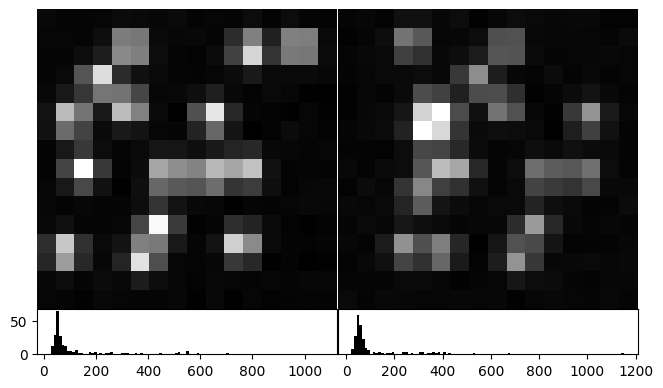

In [7]:
imgAB = imgA.pair_with(imgB)
imgAB.plot()

In [8]:
partA.info()

=== Particle Information === 
 > Number of simulated particles: 26
 > Number of active (illuminated and in FOV) particles: 15
 > Number of particles outside of FOV: 11
 > Out of plane particles: 0


In [9]:
partA.source_density_number, partA.source_density_number / cam.size

(15, 0.05859375)

In [10]:
partB.source_density_number, partB.source_density_number / cam.size

(18, 0.0703125)

In [11]:
partB.info()

=== Particle Information === 
 > Number of simulated particles: 26
 > Number of active (illuminated and in FOV) particles: 18
 > Number of particles outside of FOV: 8
 > Out of plane particles: 0


This means, that we lost the following percentage of particles out of plane:

In [12]:
partB.n_out_of_plane_loss/partA.n_active*100

0.0

## Save double images

We can save both images individually as done with a single image:

In [13]:
from synpivimage.io import imwrite16

In [14]:
imwrite16('imgA.tif',
          img=imgA[:],
          camera=cam,
          laser=laser,
          particles=partA,
          particle_peak_count=1000,
          overwrite=True)

imwrite16('imgB.tif',
          img=imgB[:],
          camera=cam,
          laser=laser,
          particles=partB,
          particle_peak_count=1000,
          overwrite=True)

WindowsPath('imgB.tif')

For **HDF** we can store everything together:

In [15]:
from synpivimage.io import hdfwrite
import h5py
import h5rdmtoolbox as h5tbx

We can choose to write both images in separate groups:

In [16]:
with h5py.File('imgAB.hdf', 'w') as h5:
    imgAgrp = h5.create_group('imgA')
    hdfwrite(imgAgrp, imgA, laser=laser, camera=cam, particles=partA)
    imgBgrp = h5.create_group('imgB')
    hdfwrite(imgBgrp, imgB, laser=laser, camera=cam, particles=partB)

h5tbx.dump('imgAB.hdf')

... or a bit more efficient by passing lists of images and let the write function to the rest:

In [17]:
with h5py.File('imgAB.hdf', 'w') as h5:
    hdfwrite(h5,
             [imgA, imgB],
             laser=laser,
             camera=cam,
             particles=[partA, partB])

h5tbx.dump('imgAB.hdf')

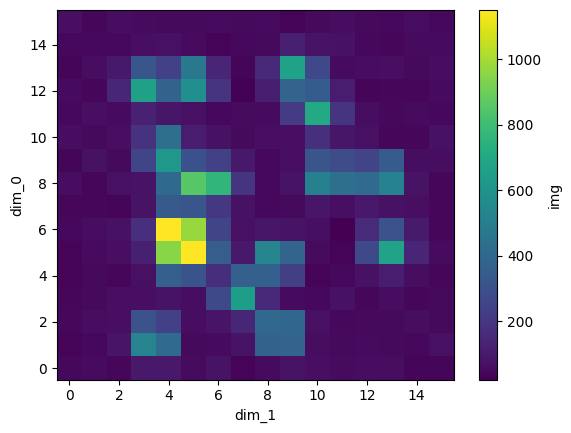

In [18]:
with h5tbx.File('imgAB.hdf', 'r') as h5:
    h5.img[1,...].plot()